In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, random_split
%matplotlib inline

In [ ]:
dataset = FashionMNIST(root='data/', download=True, transform=ToTensor())
dataset_test = FashionMNIST(root='data/', train=False, download=True, transform=ToTensor())

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
len(dataset), len(dataset_test)

(60000, 10000)

In [ ]:
train_size = 50000
val_size = len(dataset) - train_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])

In [ ]:
len(train_ds), len(val_ds), len(dataset_test)

(50000, 10000, 10000)

In [ ]:
batch_size = 64

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)
test_dl = DataLoader(dataset_test, batch_size*2, num_workers=2, pin_memory=True)

torch.Size([64, 1, 28, 28])


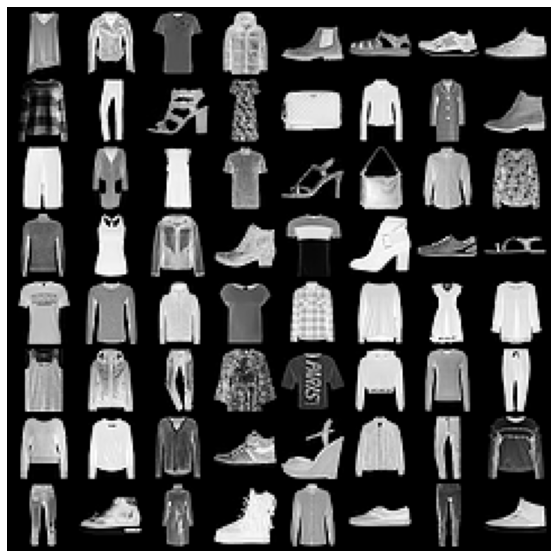

In [ ]:
for images, _ in train_dl:
  print(images.shape)
  plt.figure(figsize=(10,10))
  plt.axis('off')
  plt.imshow(make_grid(images, nrow=8).permute(1,2,0))
  break

In [ ]:
def accuracy(yp, yb):
  _, max_probs = torch.max(yp, dim=1)
  return torch.tensor(torch.sum(max_probs == yb).item() / len(max_probs))

In [ ]:
class FashionModel(nn.Module):
  def __init__(self, n_inputs, n_classes):
    super().__init__()
    # Hidden layer 1
    self.linear1 = nn.Linear(n_inputs, 64)
    # Hidden layer 2
    self.linear2 = nn.Linear(64, 32)
    # Hidden layer 3
    self.linear3 = nn.Linear(32, 16)
    # Output layer
    self.linear4 = nn.Linear(16, n_classes)

  def forward(self, xb):
    # Flatten image tensors
    out = xb.view(xb.size(0), -1)
    # Outputs of layer1
    out = self.linear1(out)
    # Apply activation function
    out = F.relu(out)
    # Outputs of layer2
    out = self.linear2(out)
    # Activation
    out = F.relu(out)
    # Outputs of layer 3
    out = self.linear3(out)
    # Activation
    out = F.relu(out)
    # Prediction
    out = self.linear4(out)
    return out

  def training_step(self, batch):
    xb, yb = batch
    yp = self(xb)
    loss = F.cross_entropy(yp, yb)
    return loss

  def validation_step(self, batch):
    xb, yb = batch
    yp = self(xb)
    loss = F.cross_entropy(yp, yb)
    acc = accuracy(yp, yb)
    return {'val_loss': loss.detach(), 'val_acc': acc}

  def validation_epoch_end(self, result):
    losses = [x['val_loss'] for x in result]
    epoch_loss = torch.stack(losses).mean()
    accs = [x['val_acc'] for x in result]
    epoch_acc = torch.stack(accs).mean()
    return {'epoch_loss': epoch_loss.item(), 'epoch_acc': epoch_acc.item()}

  def epoch_end(self, epoch, result):
    print(f'Epoch: [{epoch}], Loss: {round(result["epoch_loss"], 4)}, Accuracy: {round(result["epoch_acc"], 4)}')

In [ ]:
n_inputs = 28*28
n_classes = 10
model = FashionModel(n_inputs, n_classes)

In [ ]:
for t in model.parameters():
  print(t.shape)

torch.Size([64, 784])
torch.Size([64])
torch.Size([32, 64])
torch.Size([32])
torch.Size([16, 32])
torch.Size([16])
torch.Size([10, 16])
torch.Size([10])


In [ ]:
torch.cuda.is_available()

True

In [ ]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
def to_device(data, device):
  """Moves tensors to a chosen device"""
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

In [ ]:
class DeviceDataLoader():
  """Wrap a dataloader to move data for device"""
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    """Yield a batch of data after moving it to device"""
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    """Number of batches"""
    return len(self.dl)

In [ ]:
train_loader = DeviceDataLoader(train_dl, device)
val_loader = DeviceDataLoader(val_dl, device)
test_loader = DeviceDataLoader(test_dl, device)

In [ ]:
def evaluate(model, val_dl):
  outputs = [model.validation_step(batch) for batch in val_dl]
  return model.validation_epoch_end(outputs)

In [ ]:
def fit(n_epochs, model, train_dl, val_dl, lr, opt_f=torch.optim.SGD):
  history = []
  opt = opt_f(model.parameters(), lr)

  for epoch in range(n_epochs):
    for batch in train_dl:
      loss = model.training_step(batch)
      loss.backward()
      opt.step()
      opt.zero_grad()

    res = evaluate(model, val_dl)
    model.epoch_end(epoch, res)
    history.append(res)

  return history

In [ ]:
model = FashionModel(n_inputs, n_classes)
to_device(model, device)

FashionModel(
  (linear1): Linear(in_features=784, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=32, bias=True)
  (linear3): Linear(in_features=32, out_features=16, bias=True)
  (linear4): Linear(in_features=16, out_features=10, bias=True)
)

In [ ]:
history = [evaluate(model, val_loader)]
history

[{'epoch_acc': 0.09938686341047287, 'epoch_loss': 2.3061540126800537}]

In [ ]:
history += fit(5, model, train_loader, val_loader, 0.5)

Epoch: [0], Loss: 0.7888, Accuracy: 0.7455
Epoch: [1], Loss: 0.5083, Accuracy: 0.8166
Epoch: [2], Loss: 0.5897, Accuracy: 0.7902
Epoch: [3], Loss: 0.4727, Accuracy: 0.8284
Epoch: [4], Loss: 0.6568, Accuracy: 0.7532


In [ ]:
history += fit(30, model, train_loader, val_loader, 0.001)

Epoch: [0], Loss: 0.4267, Accuracy: 0.8524
Epoch: [1], Loss: 0.3958, Accuracy: 0.861
Epoch: [2], Loss: 0.3881, Accuracy: 0.8615
Epoch: [3], Loss: 0.3851, Accuracy: 0.8623
Epoch: [4], Loss: 0.3835, Accuracy: 0.8636
Epoch: [5], Loss: 0.3823, Accuracy: 0.8642
Epoch: [6], Loss: 0.3813, Accuracy: 0.8637
Epoch: [7], Loss: 0.3806, Accuracy: 0.8639
Epoch: [8], Loss: 0.3799, Accuracy: 0.864
Epoch: [9], Loss: 0.3794, Accuracy: 0.864
Epoch: [10], Loss: 0.379, Accuracy: 0.8648
Epoch: [11], Loss: 0.3786, Accuracy: 0.8644
Epoch: [12], Loss: 0.3782, Accuracy: 0.8642
Epoch: [13], Loss: 0.3779, Accuracy: 0.8652
Epoch: [14], Loss: 0.3777, Accuracy: 0.8647
Epoch: [15], Loss: 0.3774, Accuracy: 0.8649
Epoch: [16], Loss: 0.3771, Accuracy: 0.8645
Epoch: [17], Loss: 0.3767, Accuracy: 0.8647
Epoch: [18], Loss: 0.3764, Accuracy: 0.8648
Epoch: [19], Loss: 0.3762, Accuracy: 0.8647
Epoch: [20], Loss: 0.376, Accuracy: 0.8645
Epoch: [21], Loss: 0.3758, Accuracy: 0.8642
Epoch: [22], Loss: 0.3754, Accuracy: 0.8645
Epo

In [ ]:
history += fit(10, model, train_loader, val_loader, 0.01)

Epoch: [0], Loss: 0.3725, Accuracy: 0.8653
Epoch: [1], Loss: 0.3706, Accuracy: 0.8672
Epoch: [2], Loss: 0.371, Accuracy: 0.8666
Epoch: [3], Loss: 0.3688, Accuracy: 0.8678
Epoch: [4], Loss: 0.3685, Accuracy: 0.8679
Epoch: [5], Loss: 0.3687, Accuracy: 0.8672
Epoch: [6], Loss: 0.3679, Accuracy: 0.8686
Epoch: [7], Loss: 0.3671, Accuracy: 0.8684
Epoch: [8], Loss: 0.3657, Accuracy: 0.8698
Epoch: [9], Loss: 0.3664, Accuracy: 0.8684


In [ ]:
history += fit(30, model, train_loader, val_loader, 0.1)

Epoch: [0], Loss: 0.3709, Accuracy: 0.8662
Epoch: [1], Loss: 0.3739, Accuracy: 0.8634
Epoch: [2], Loss: 0.3795, Accuracy: 0.8616
Epoch: [3], Loss: 0.372, Accuracy: 0.8686
Epoch: [4], Loss: 0.3632, Accuracy: 0.8705
Epoch: [5], Loss: 0.3703, Accuracy: 0.8707
Epoch: [6], Loss: 0.3759, Accuracy: 0.8713
Epoch: [7], Loss: 0.3546, Accuracy: 0.8743
Epoch: [8], Loss: 0.3638, Accuracy: 0.871
Epoch: [9], Loss: 0.3683, Accuracy: 0.8722
Epoch: [10], Loss: 0.3666, Accuracy: 0.8698
Epoch: [11], Loss: 0.5038, Accuracy: 0.827
Epoch: [12], Loss: 0.3876, Accuracy: 0.8618
Epoch: [13], Loss: 0.372, Accuracy: 0.8705
Epoch: [14], Loss: 0.3681, Accuracy: 0.8704
Epoch: [15], Loss: 0.4152, Accuracy: 0.8524
Epoch: [16], Loss: 0.3853, Accuracy: 0.8685
Epoch: [17], Loss: 0.3607, Accuracy: 0.8766
Epoch: [18], Loss: 0.3462, Accuracy: 0.8782
Epoch: [19], Loss: 0.3902, Accuracy: 0.8683
Epoch: [20], Loss: 0.3635, Accuracy: 0.8763
Epoch: [21], Loss: 0.3648, Accuracy: 0.877
Epoch: [22], Loss: 0.3647, Accuracy: 0.8717
Epo

In [ ]:
history += fit(5, model, train_loader, val_loader, 0.2)

Epoch: [0], Loss: 0.4075, Accuracy: 0.859
Epoch: [1], Loss: 0.4097, Accuracy: 0.8631
Epoch: [2], Loss: 0.504, Accuracy: 0.8177
Epoch: [3], Loss: 0.3999, Accuracy: 0.8654
Epoch: [4], Loss: 0.4891, Accuracy: 0.8416


In [ ]:
history += fit(5, model, train_loader, val_loader, 0.3)

Epoch: [0], Loss: 0.4151, Accuracy: 0.8629
Epoch: [1], Loss: 0.4589, Accuracy: 0.8389
Epoch: [2], Loss: 0.4319, Accuracy: 0.8512
Epoch: [3], Loss: 0.3741, Accuracy: 0.8712
Epoch: [4], Loss: 0.4575, Accuracy: 0.8538


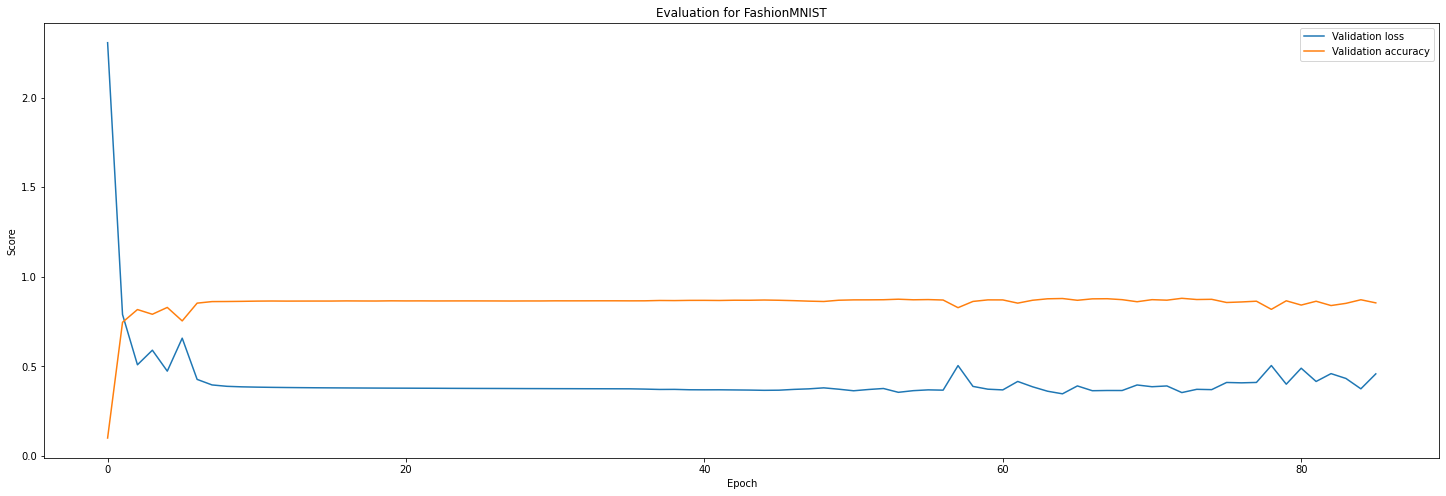

In [ ]:
losses = [x['epoch_loss'] for x in history]
accs = [x['epoch_acc'] for x in history]
plt.figure(figsize=(25, 8))
plt.plot(losses, label='Validation loss')
plt.plot(accs, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Evaluation for FashionMNIST')
plt.legend();

In [ ]:
evaluate(model, test_loader)

{'epoch_acc': 0.8477057218551636, 'epoch_loss': 0.4703722596168518}

In [ ]:
saved_weights_fname='fashion-feedforward.pth'

In [ ]:
torch.save(model.state_dict(), saved_weights_fname)